# Preparing the NoteBook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os, shutil
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import pandas as pd
import MDAnalysis as MDAnalysis
import MDAnalysis.analysis.hbonds.hbond_analysis
import MDAnalysis.analysis.distances
import mdtraj as md
import pytraj as pt
import nglview as nv
import seaborn as sns
#sns.set()

In [3]:
# Matplotlib options
%matplotlib inline
matplotlib.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 12, 8

# DHFR files

In [4]:
dir_system="/DATA/projects/Learning_Python/MD_Analysis_examples/dhfr-solv/"

In [5]:
filename_traj="traj_comp.xtc"
filename_coors="dhfr_23558.gro"
filename_top="dhfr_23558.top"

In [6]:
file_traj=dir_system+filename_traj
file_coors=dir_system+filename_coors
file_top=dir_system+filename_top

# DHFR Visualization (structure and trajectory)

In [38]:
md_coors = md.load(file_coors)
md_coors.remove_solvent()
view = nv.show_mdtraj(md_coors)
view

NGLWidget()

In [39]:
md_traj = md.load(file_traj, top=file_coors)
md_traj.remove_solvent()
md_traj.center_coordinates()
traj_view = nv.show_mdtraj(md_traj)
traj_view

NGLWidget(count=20001)

# Least RMSD with frame 0 as reference

Have a look to: https://towardsdatascience.com/tensorflow-rmsd-using-tensorflow-for-things-it-was-not-designed-to-do-ada4c9aa0ea2
Dou you know what quaternions are?

In [9]:
rmsds = md.rmsd(md_traj, md_traj, 0, precentered=True) # md_traj.center_coordinates() was executed before

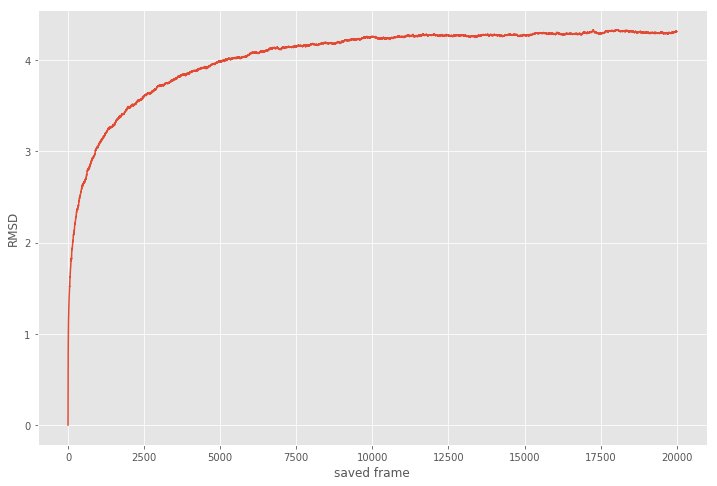

In [10]:
plt.plot(rmsds)
plt.xlabel("saved frame")
plt.ylabel("RMSD")
plt.show()

In [11]:
del(md_traj)

# H bonds with water

In [12]:
u = MDAnalysis.Universe(file_coors,file_traj) 

/opt/apps/conda/intel-2018.1.163_miniconda/envs/MDLab3/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [13]:
print("Number of atoms:",len(u.atoms),"  Number of frames:", len(u.trajectory))

Number of atoms: 23558   Number of frames: 20001


In [14]:
print(u.residues.resnames)

['MET' 'ILE' 'SER' ..., 'WAT' 'WAT' 'WAT']


In [15]:
group_O_wats=u.select_atoms('name O and resname WAT')

for atom in group_O_wats.atoms:
    atom.name='OW'

In [16]:
h = MDAnalysis.analysis.hbonds.HydrogenBondAnalysis(u, 'protein', 'resname WAT', distance=3.0, angle=120.0, step=1, filter_first=True)
h.run()

HBonds frame 20000: 20001/20001 [100.0%]


In [17]:
h.generate_table()
hbonds_table=h.table
hbonds_timeseries=h.timeseries
num_hbonds_per_frame=[len(ii) for ii in hbonds_timeseries]

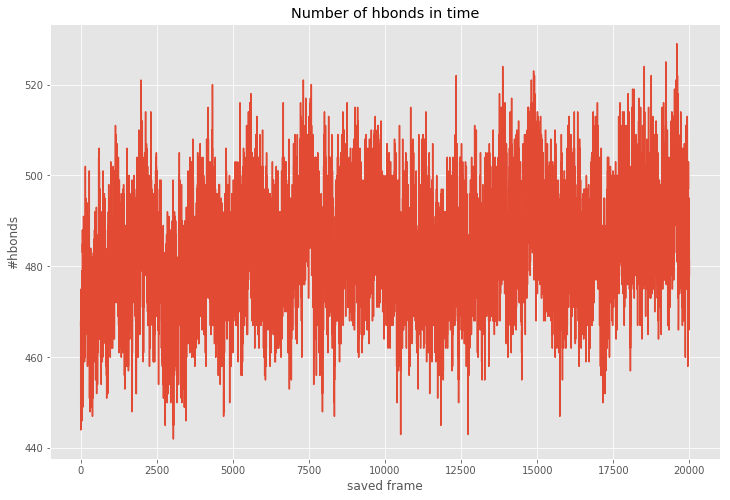

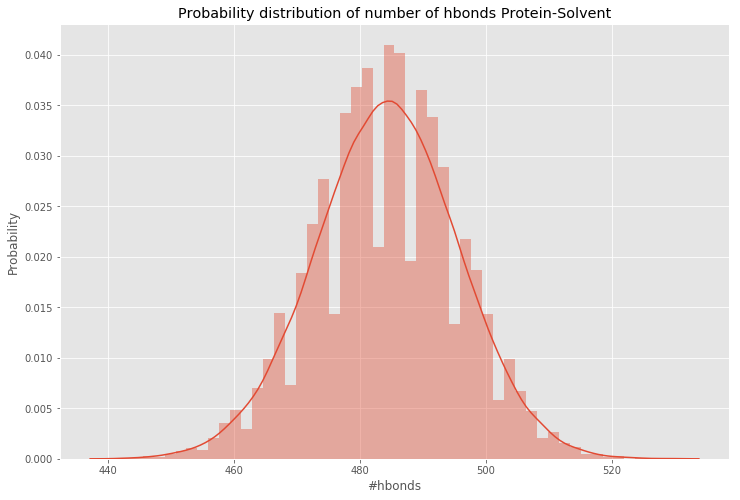

In [18]:
plt.plot(num_hbonds_per_frame)
plt.xlabel("saved frame")
plt.ylabel("#hbonds")
plt.title("Number of hbonds in time")
plt.show()

sns.distplot(num_hbonds_per_frame)
plt.xlabel("#hbonds")
plt.ylabel("Probability")
plt.title("Probability distribution of number of hbonds Protein-Solvent")
plt.show()

In [19]:
waters_hbonded={} # Counting number of frames a given water molecule is hbonded to the protein
aminoacids_hbonded={} # Counting number of frames a given aa is hbonded to the solvent
for hbonds_frame in hbonds_timeseries:
    resids_hbonded_in_frame=[]
    for hbond in hbonds_frame:
        res1=hbond[2].split(':')[0]
        res2=hbond[3].split(':')[0]
        resids_hbonded_in_frame.extend([res1,res2])
    resids_hbonded_in_frame=np.unique(resids_hbonded_in_frame)
    for resid in resids_hbonded_in_frame:
        if resid.startswith('WAT'):
            if resid in waters_hbonded.keys():
                waters_hbonded[resid]+=1
            else:
                waters_hbonded[resid]=1
        else:
            if resid in aminoacids_hbonded.keys():
                aminoacids_hbonded[resid]+=1
            else:
                aminoacids_hbonded[resid]=1

In [20]:
# Waters: number of frames solvating the protein

group_waters=u.select_atoms('resname WAT')
print('De', group_waters.n_residues, 'aguas, ',len(waters_hbonded),'solvataron la proteina en algún momento.')
print('Estamos cerca del equilibrio si miramos la posibilidad de un agua de solvatar a la proteina?')
print('')


De 7023 aguas,  6254 solvataron la proteina en algún momento.
Estamos cerca del equilibrio si miramos la posibilidad de un agua de solvatar a la proteina?



In [21]:
waters={}

for resid in group_waters.residues:
    waters[resid.resname+str(resid.resid)]=0
    
for water_name in waters_hbonded.keys():
    waters[water_name]=waters_hbonded[water_name]



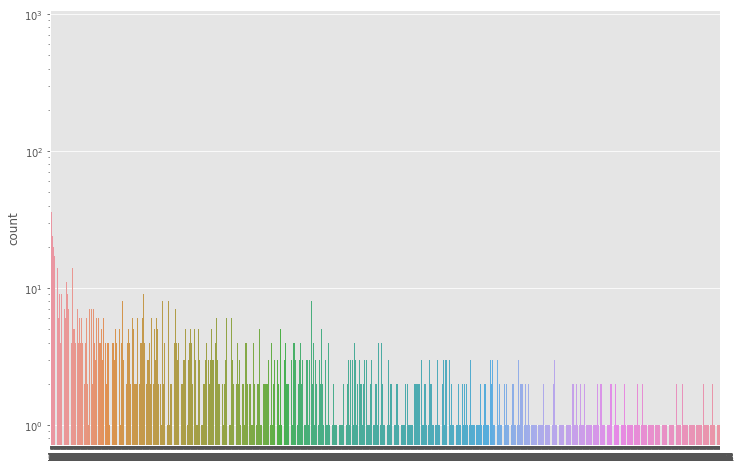

In [37]:
sns.countplot(list(waters.values()))
plt.yscale('log')

In [23]:
water_hbonded_max=max(waters_hbonded, key=waters_hbonded.get)
print('The water molecule named',water_hbonded_max,'stays ',waters_hbonded[water_hbonded_max],'frames hbonded')

The water molecule named WAT4864 stays  20001 frames hbonded


In [24]:
md_traj = md.load(file_traj, top=file_coors)
md_traj

<mdtraj.Trajectory with 20001 frames, 23558 atoms, 7182 residues, and unitcells at 0x2ab2c7da8ef0>

In [41]:
del(view1)
view1 = nv.show_mdtraj(md_traj)
view1.clear_representations()
view1.add_cartoon('protein')
view1.add_licorice('resi 4864')
view1

NGLWidget(count=20001)

In [27]:
# Residues: number of frames solvated 

group_aminoacids=u.select_atoms('protein')
print('In', group_aminoacids.n_residues, 'residues, ',len(aminoacids_hbonded),'were solvated atleast one frame')
print('')


In 159 residues,  148 were solvated atleast one frame



In [28]:
aminoacids={}

for resid in group_aminoacids.residues:
    aminoacids[resid.resname+str(resid.resid)]=0
    
for aminoacid_name in aminoacids_hbonded.keys():
    aminoacids[aminoacid_name]=aminoacids_hbonded[aminoacid_name]

<Container object of 159 artists>

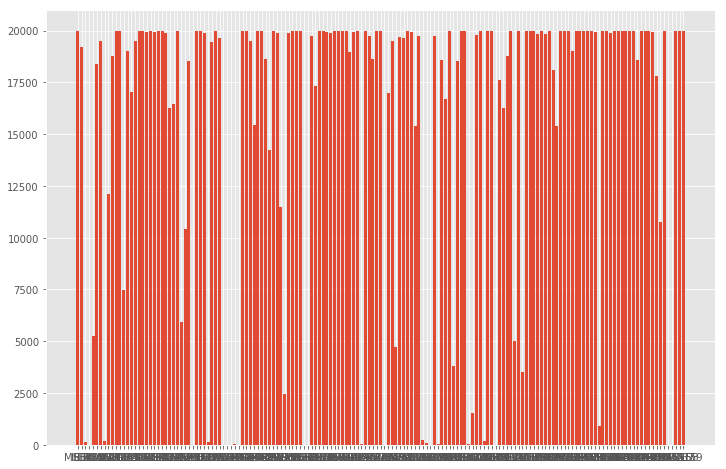

In [29]:
names = list(aminoacids.keys())
values = list(aminoacids.values())

plt.bar(range(len(aminoacids)),values,tick_label=names)

In [30]:
aminoacid_hbonded_max=max(aminoacids_hbonded, key=aminoacids_hbonded.get)
print('The residue',aminoacid_hbonded_max,'stays ',aminoacids_hbonded[aminoacid_hbonded_max],'frames hbonded')

The residue ARG12 stays  20001 frames hbonded


In [42]:
del(view2)
view2 = nv.show_mdtraj(md_traj)
view2.clear_representations()
view2.add_cartoon('protein')
view2.add_licorice('resi 12')
view2

NGLWidget(count=20001)

# Distance C-terminal and N-terminal

In [32]:
def distance_terms(u):
    sel_N_term=u.select_atoms("resid 1 and (name N)")
    sel_C_term=u.select_atoms("resid 159 and (name C)")
    return MDAnalysis.analysis.distances.dist(sel_N_term,sel_C_term)[2,0]

In [33]:
dist=np.array([(u.trajectory.time, distance_terms(u)) for ts in u.trajectory])

In [34]:
print(dist.shape)

(20001, 2)


Text(0,0.5,'dist N_term-C_term')

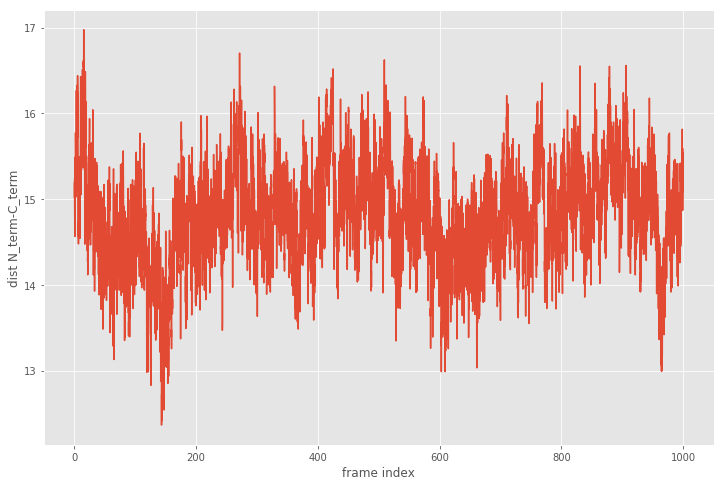

In [35]:
plt.plot(dist[:,0],dist[:,1])
plt.xlabel("frame index")
plt.ylabel("dist N_term-C_term")

In [43]:
del(view3)
view3 = nv.show_mdtraj(md_traj)
view3.clear_representations()
view3.add_cartoon('protein')
view3.add_licorice('resi 1 159')
view3

NGLWidget(count=20001)

In [ ]:
help(view3.add_distance())